## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.layers import Input, Dense, Layer, BatchNormalization, Dropout, RepeatVector
from keras.layers import Lambda, Conv2D, Flatten, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D, TimeDistributed
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Model, model_from_json
from keras import backend as K
#from keras import objectives
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from glob import glob
from multiprocessing import Pool
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from time import time
import datetime
import os

Using TensorFlow backend.


## モデルの読み込み

In [16]:
!ls ../output

abnorm1.gif
abnorm2.gif
abnorm3.gif
conv_vae_best_param_20190106_151624.hdf5
conv_vae_best_param_20190107_045912.hdf5
conv_vae_best_param_20190107_074233.hdf5
conv_vae_best_param.hdf5
conv_vae_decoder_20190107_045912.json
conv_vae_decoder_20190107_073111.json
conv_vae_decoder_20190107_074233.json
conv_vae_decoder_best_param_20190107_045912.hdf5
conv_vae_decoder_best_param_20190107_074233.hdf5
conv_vae_encoder_20190107_045912.json
conv_vae_encoder_20190107_073111.json
conv_vae_encoder_20190107_074233.json
conv_vae_encoder_best_param_20190107_045912.hdf5
conv_vae_encoder_best_param_20190107_074233.hdf5
conv_vae_init_param_20190106_141204.hdf5
conv_vae_init_param_20190106_142228.hdf5
conv_vae_init_param_20190106_142904.hdf5
conv_vae_init_param_20190106_151624.hdf5
conv_vae_init_param_20190107_045912.hdf5
conv_vae_init_param_20190107_074233.hdf5
conv_vae_model_20190106_141204.json
conv_vae_model_20190106_142228.json
conv_vae_model_20190106_142904.json
conv_vae_model_20190106_151624.json
co

In [6]:
with open("../output/") as f:
    json_string = f.readline()

In [7]:
model = model_from_json(json_string)
model.load_weights("../output/conv_vae_best_param_20190107_074233.hdf5")

## データの前処理

In [8]:
!ls ../data/shogi_pose_dataset/

AbemaTV_Tournament_Final1	 fujii_vs_kondo_Ablock_2_2_1080p
AbemaTV_Tournament_Final2	 fujii_vs_takami_semi_1_1080p
AbemaTV_Tournament_Final3	 fujii_vs_takami_semi_2_1080p
fujii_vs_kondo_Ablock_1_1080p	 fujii_vs_takami_semi_3_1080p
fujii_vs_kondo_Ablock_2_1_1080p


In [9]:
#dirs_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final*"))
data_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final3/*"))

In [10]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    size = 32
    
    
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 150) or (width < 150):
            return np.zeros((size, size))
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return img_bin * 255.0
    except:
        return np.zeros((size, size))

In [11]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [12]:
imgs = []
with tqdm(total=len(data_path)) as pbar:
    with Pool(mp.cpu_count()) as p:
        for img in tqdm(p.imap_unordered(read_img, data_path)):
            imgs.append(img)
            pbar.update()

### 画像を4フレームごとに分割
- 4フレーム(1秒)のデータを5フレームごとにスライドしてデータを作成する。

In [13]:
stride = 5
time = 5

vids = []
for idx in tqdm(range((len(imgs) // 5) - 1)):
    vids.append(np.array(imgs[idx * stride: time + idx * stride]))

In [14]:
vids_num, time, height, width = np.array(vids).shape

vids = np.array(vids).reshape(vids_num, time, height, width, 1)[:10]

print(vids.shape)

(10, 5, 32, 32, 1)


## モデルによる生成

In [15]:
vids_pred = model.predict(vids)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (10, 5, 32, 32, 1)

In [26]:
v_show = vids[5].reshape(5,32,32)
p_show = vids_pred[5].reshape(5,32,32)

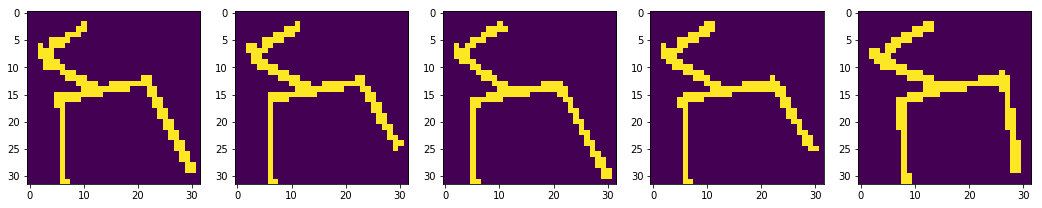

In [27]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    ax[i].imshow(v_show[i])
plt.show()

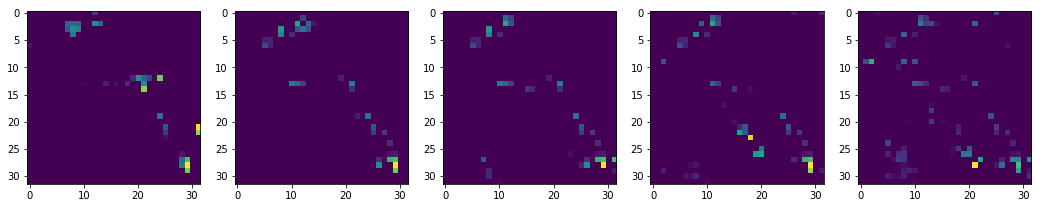

In [28]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    ax[i].imshow(p_show[i])
plt.show()

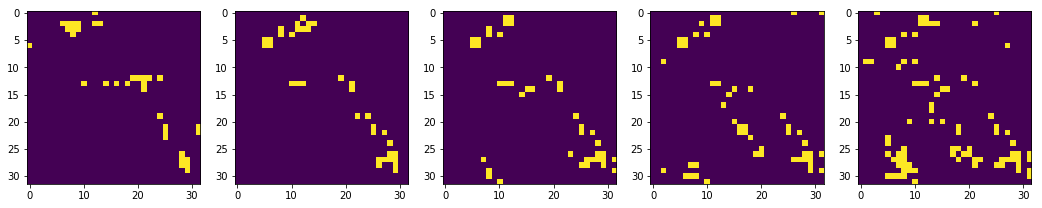

In [29]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    _, img = cv2.threshold(p_show[i], 0, 1, cv2.THRESH_BINARY)
    ax[i].imshow(img)
plt.show()